##### dados historicos da mudanca climatica na India, 2014 à 2017 na cda de Delhi.


##### Objetivo acessa  o dataset e analisar todos os componentes de séries temporais, mostrando sua tendencia, sazonalidade e ruídos. Criar um algoritmo preditivo.


In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from Utils import plot_ts, plot_decompose, augmented_dickey_fuller
import warnings
warnings.filterwarnings('ignore')

In [442]:
df_train = pd.read_csv('Data/DailyDelhiClimateTrain.csv', parse_dates=[0], index_col='date')
df_train.tail()

meantemp    humidity  wind_speed  meanpressure
date                                                       
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

In [443]:
df_test = pd.read_csv('Data/DailyDelhiClimateTest.csv', parse_dates=[0], index_col='date')
df_test.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333

In [444]:
df_train.shape

(1462, 4)

In [445]:
df_test.shape

(114, 4)

In [446]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [447]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


In [448]:
df_train.duplicated().sum()

0

In [449]:
df_train.loc['2013-01-05']

meantemp           6.000000
humidity          86.833333
wind_speed         3.700000
meanpressure    1016.500000
Name: 2013-01-05 00:00:00, dtype: float64

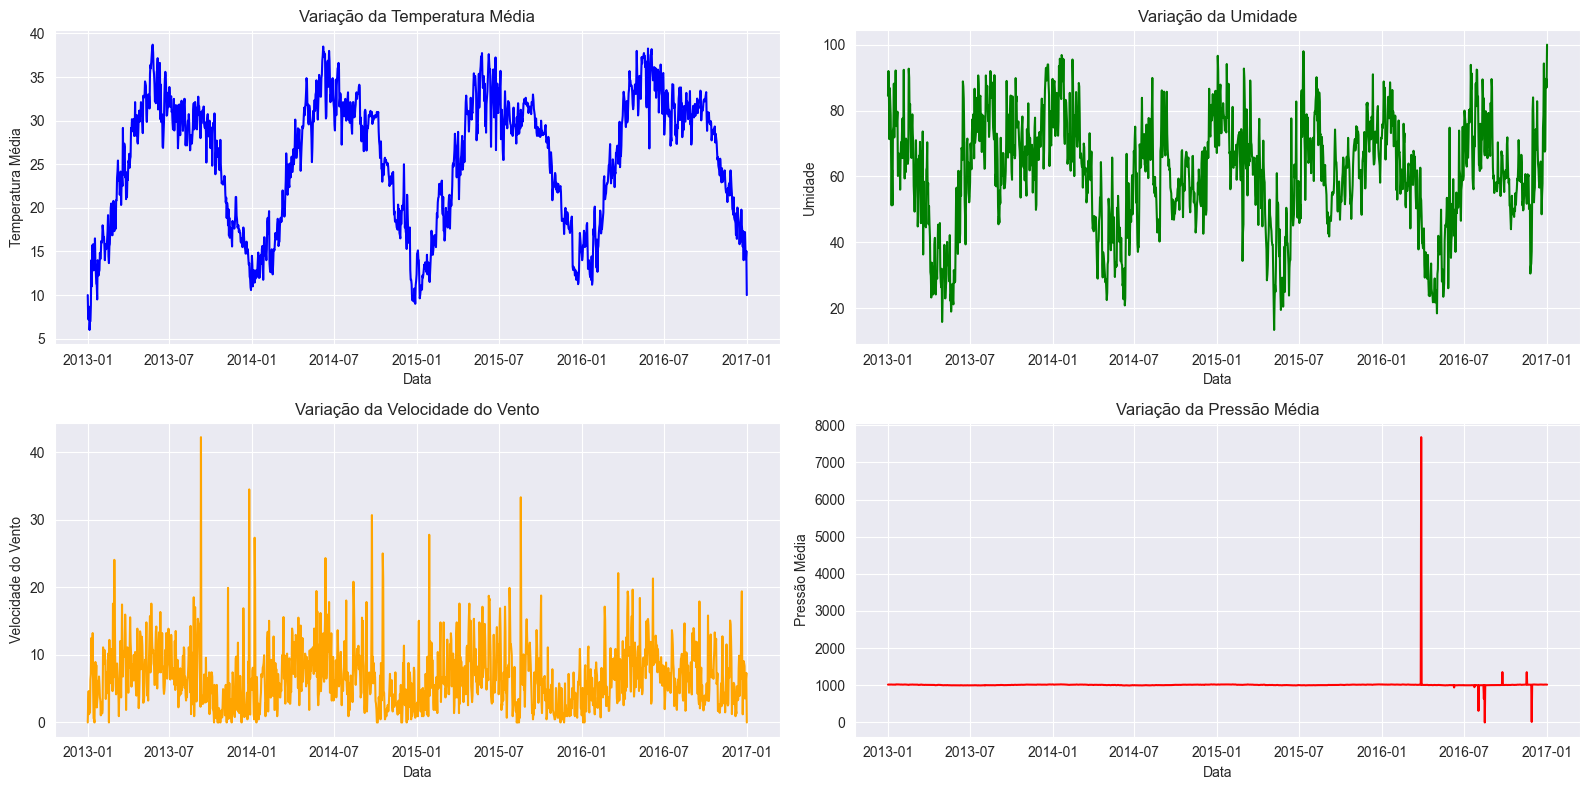

In [450]:
plot_ts(df_train)

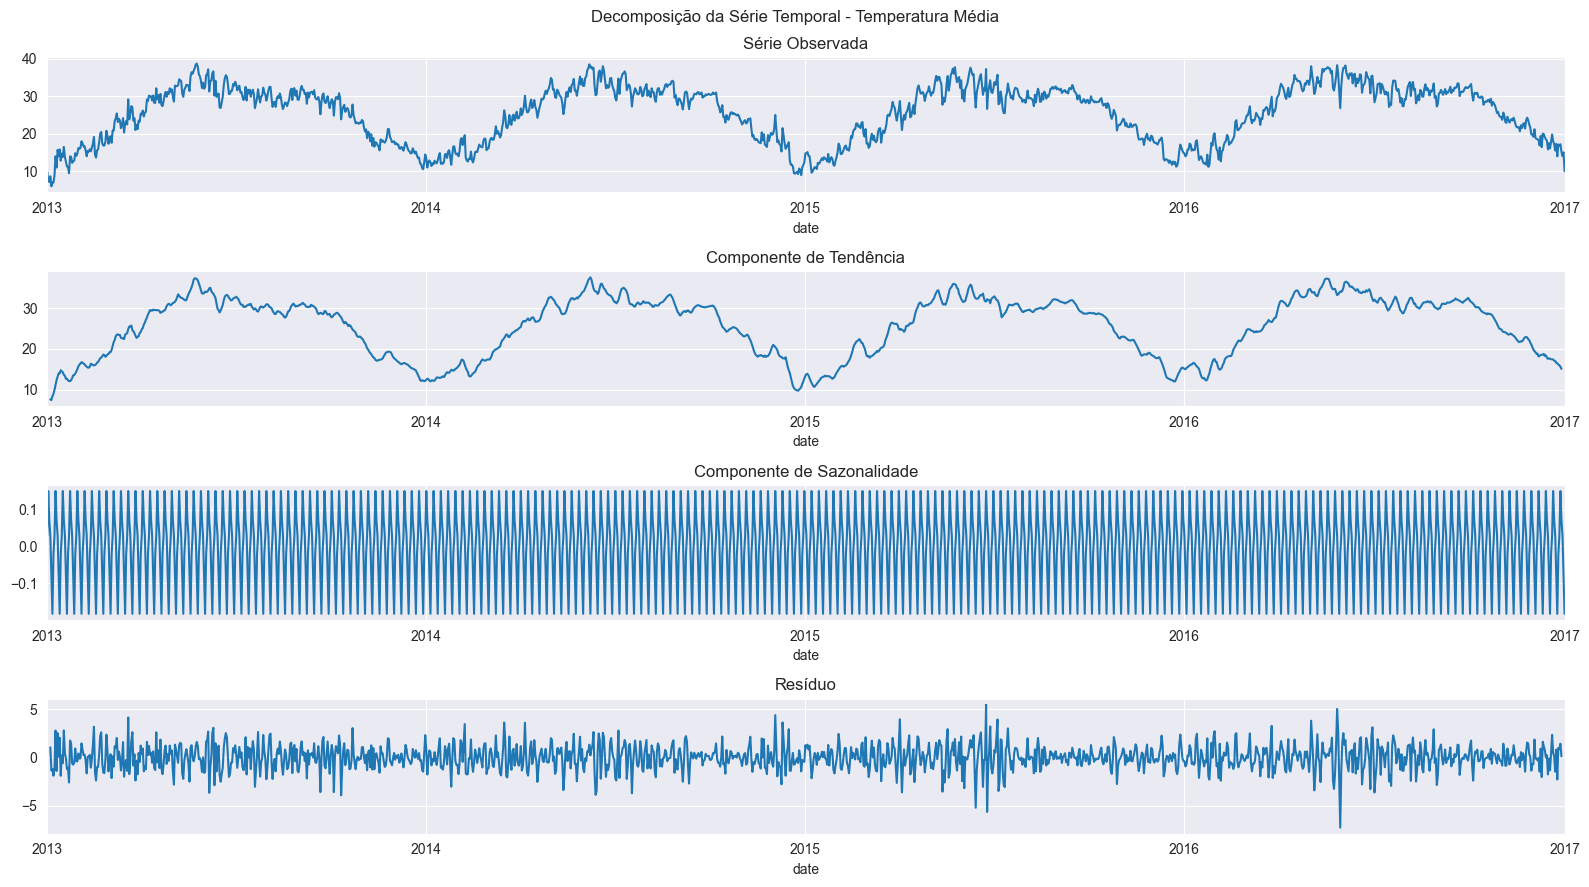

In [451]:
plot_decompose(df_train.meantemp, 'Decomposição da Série Temporal - Temperatura Média')

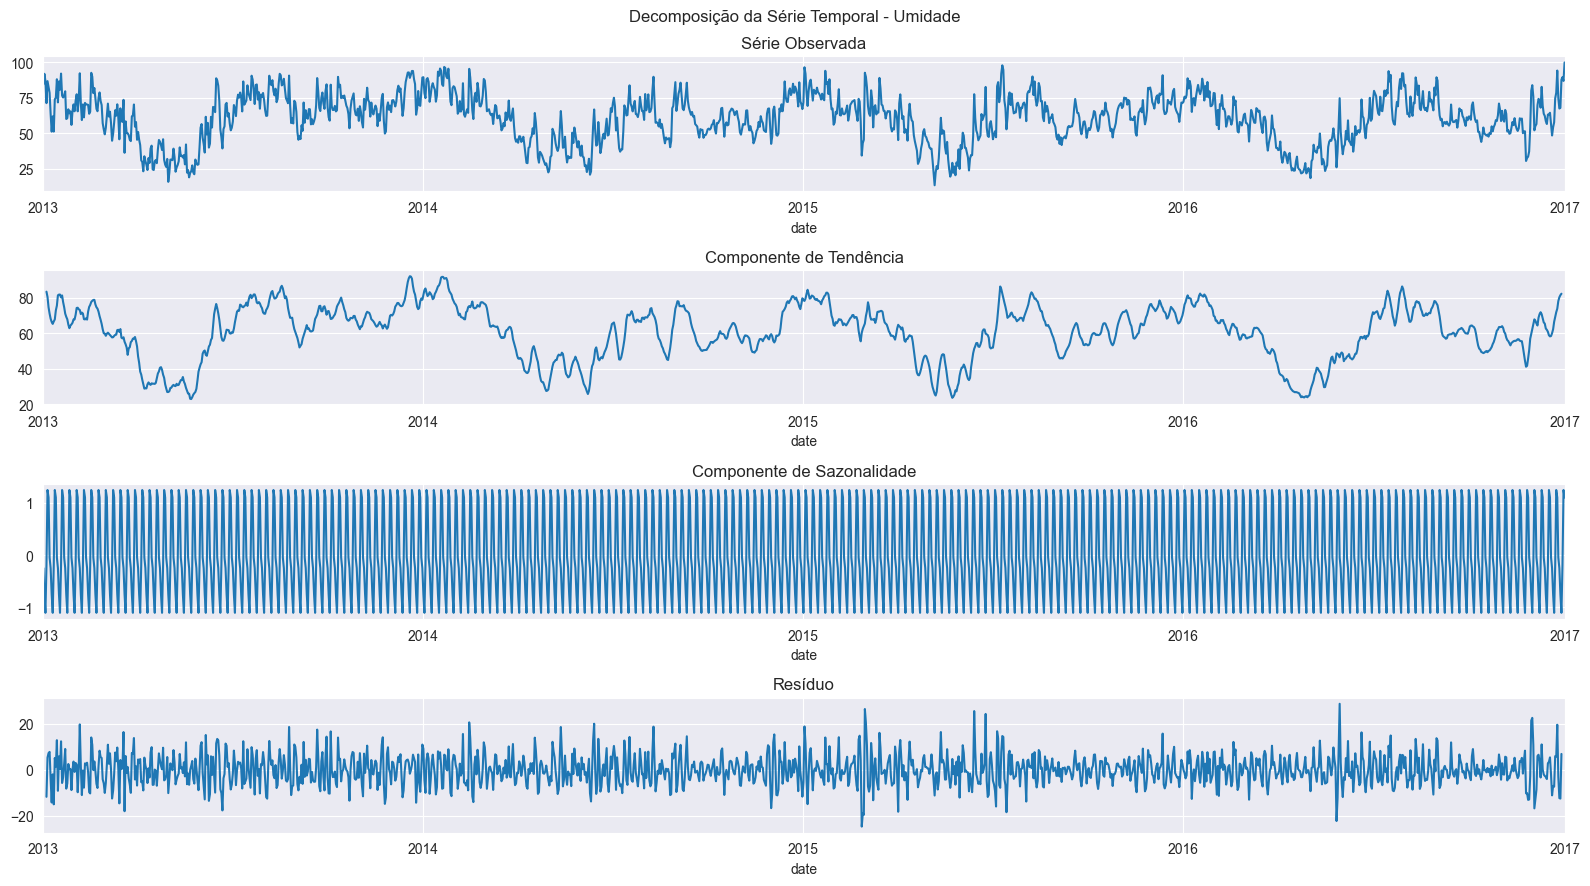

In [452]:
plot_decompose(df_train.humidity, 'Decomposição da Série Temporal - Umidade')

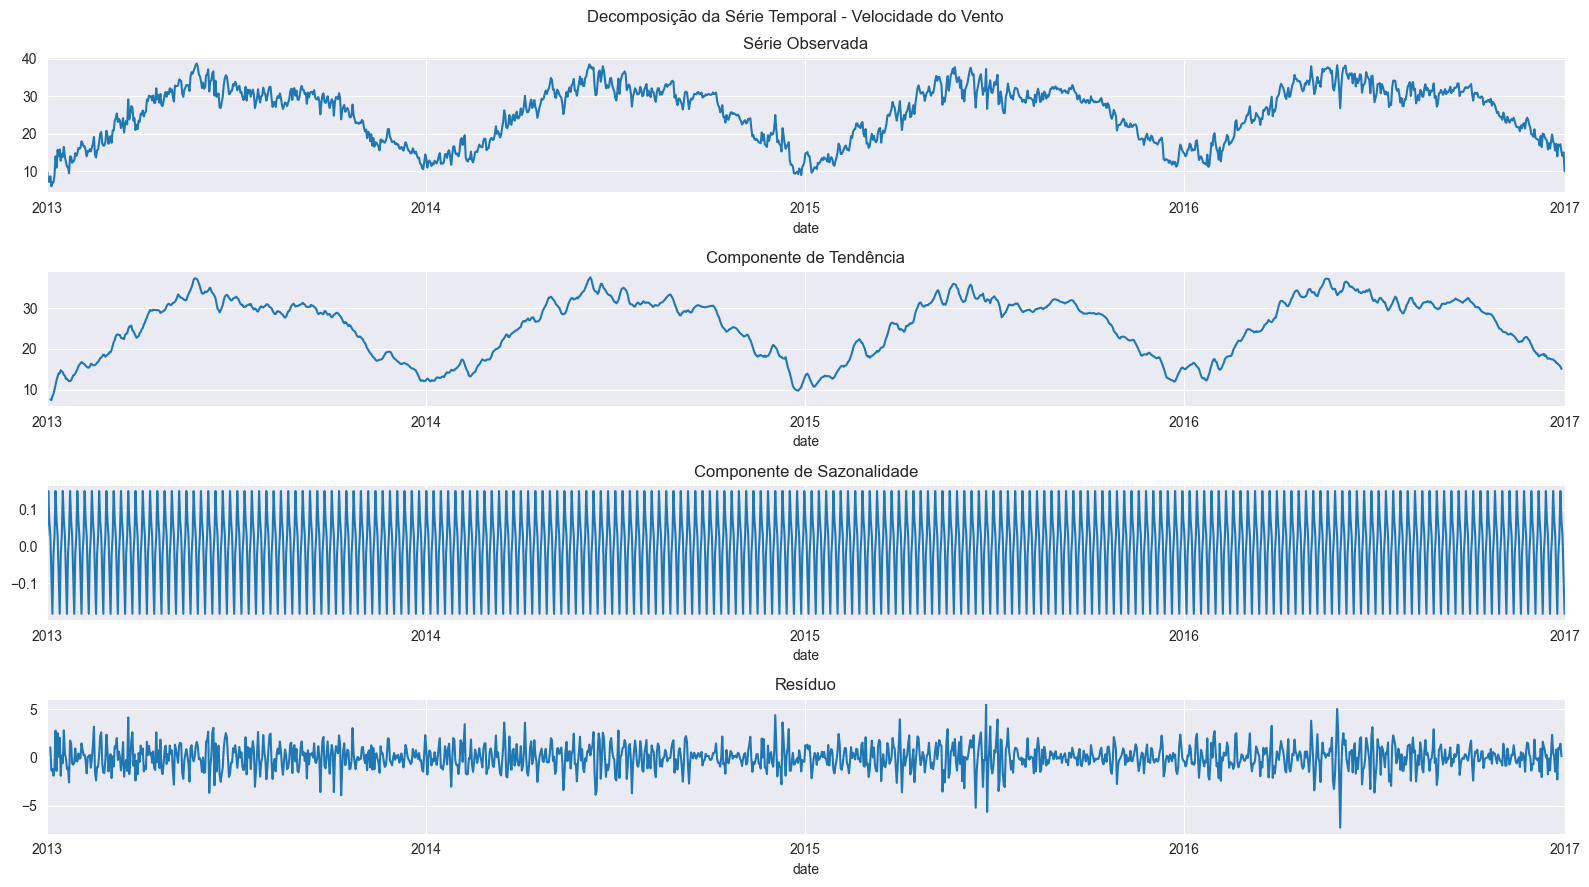

In [453]:
plot_decompose(df_train.meantemp, 'Decomposição da Série Temporal - Velocidade do Vento')

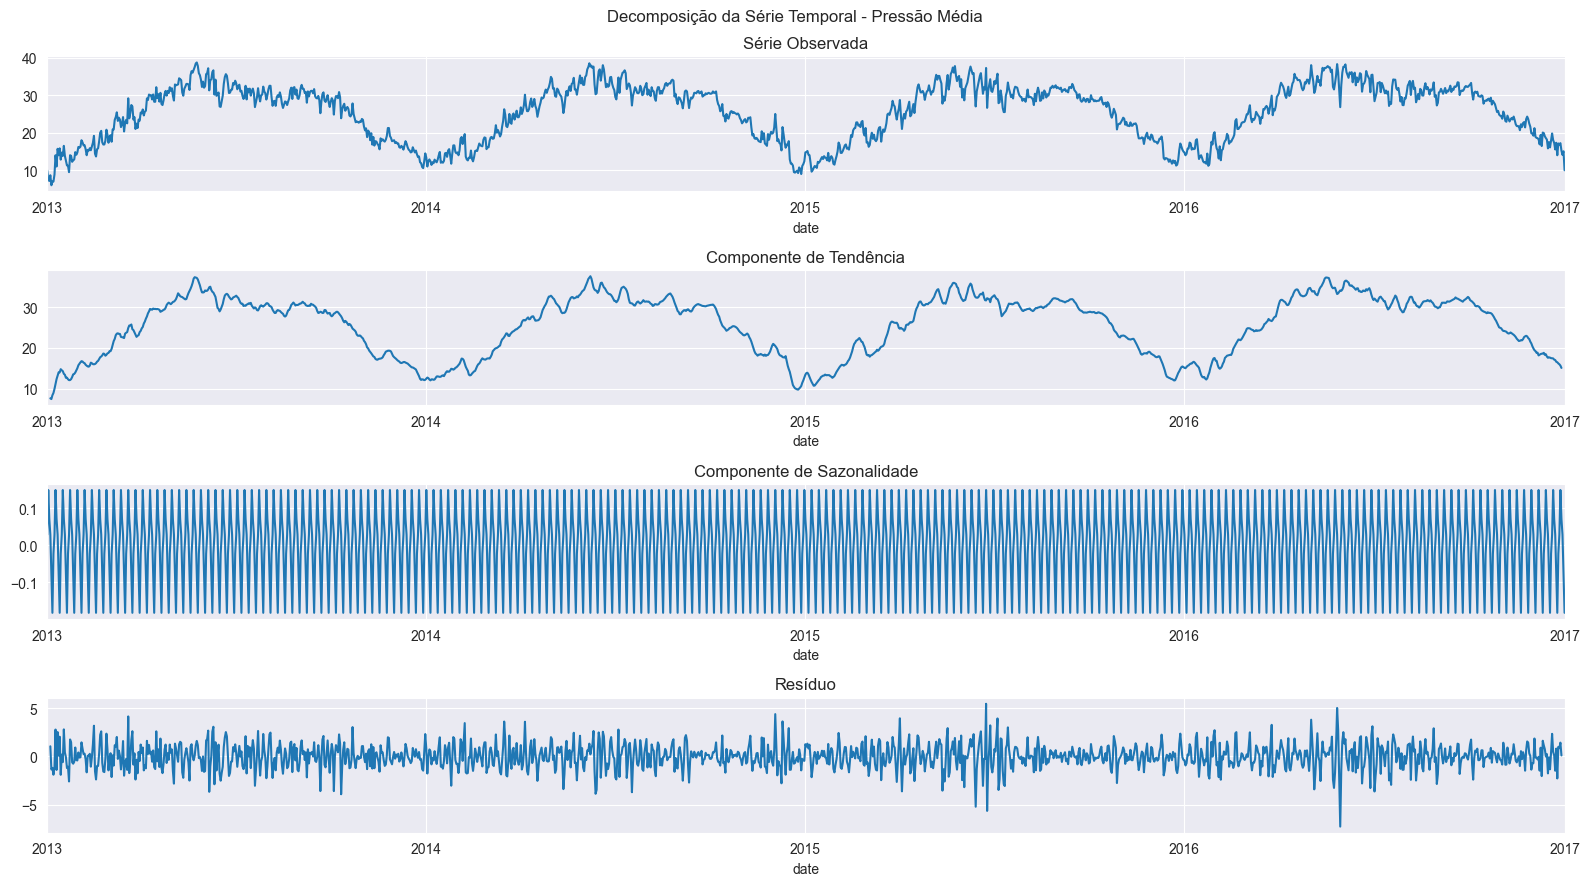

In [454]:
plot_decompose(df_train.meantemp, 'Decomposição da Série Temporal - Pressão Média')

> Hipótese
---
- H0 - Hipótese Nula (não é estacionária) não é estacionaria
- H1 - Hipótese Alternativa (rejeição da hipótese nula) é estacionaria

In [455]:
sns.set_style('darkgrid')

#### Teste Augmented Dickey Fuller (meantemp)

In [456]:
augmented_dickey_fuller(df_train.meantemp.values)

Teste ADf
Teste estatistico: -2.021069055920667
P-Value: 0.2774121372301629
Valores criticos:
	1%: -3.4348647527922824
	5%: -2.863533960720434
	10%: -2.567831568508802


> Resultado
---
- p-value 27% e teste estatístico maior que os valores criticos: Não é estacionaria

#### Teste Augmented Dickey Fuller (humidity)

In [457]:
augmented_dickey_fuller(df_train.humidity.values)

Teste ADf
Teste estatistico: -3.6755769191633383
P-Value: 0.004470100478130771
Valores criticos:
	1%: -3.434880391815318
	5%: -2.8635408625359315
	10%: -2.5678352438452814


> Resultado
---
- p-value 0.005% e teste estatístico menor que os valores criticos: É estacionaria

#### Teste Augmented Dickey Fuller (wind_speed)

In [458]:
augmented_dickey_fuller(df_train.wind_speed.values)

Teste ADf
Teste estatistico: -3.838096756685106
P-Value: 0.0025407221531463936
Valores criticos:
	1%: -3.434908816804013
	5%: -2.863553406963303
	10%: -2.5678419239852994


> Resultado
---
- p-value 0.003% e teste estatístico menor que os valores criticos: É estacionaria

In [459]:
augmented_dickey_fuller(df_train.meanpressure.values)

Teste ADf
Teste estatistico: -38.07859002556162
P-Value: 0.0
Valores criticos:
	1%: -3.434833796443757
	5%: -2.8635202989550756
	10%: -2.567824293398847


p-value 0.0% e teste estatístico menor que os valores criticos: É estacionaria

#### Converter meantemp em estacionária
---
- remover tendencia e sazonalidade, fazer a aproximação(transformada logaritmo e subtrair da média móvel)
- média móvel aplicada a linha da tendencia
- uma janela móvel de tamanho 12 meses é aplicada sobre os dados
- aplicar log
- subtrair a média móvel

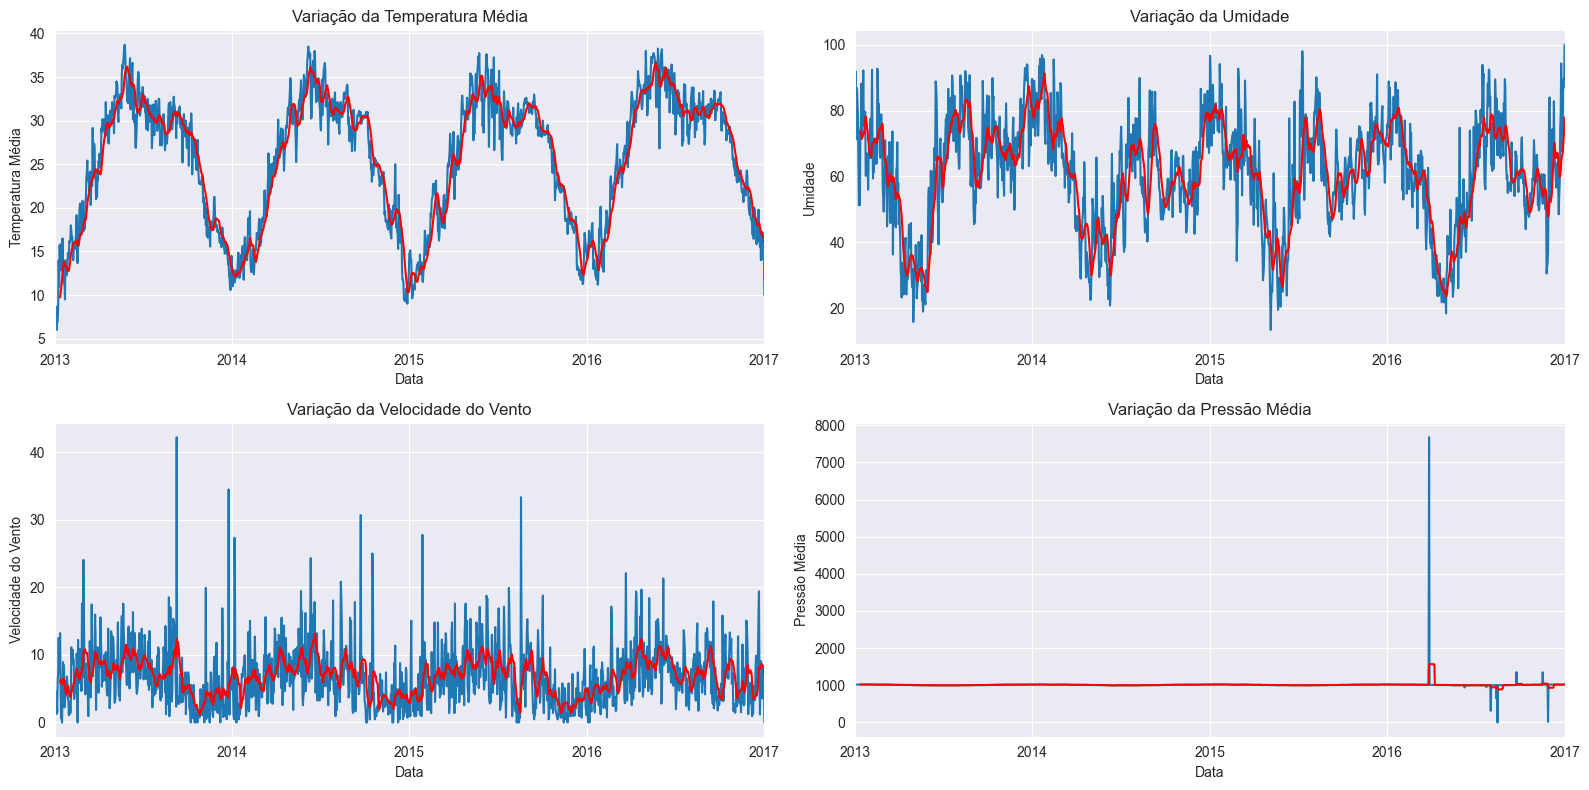

In [460]:
ma = df_train.rolling(12).mean()
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
df_train.meantemp.plot(ax=ax[0][0], legend=False)
ma.meantemp.plot(ax=ax[0][0], legend=False, color='r')
ax[0][0].set_xlabel('Data')
ax[0][0].set_ylabel('Temperatura Média')
ax[0][0].set_title('Variação da Temperatura Média')
df_train.humidity.plot(ax=ax[0][1], legend=False)
ma.humidity.plot(ax=ax[0][1], legend=False, color='r')
ax[0][1].set_xlabel('Data')
ax[0][1].set_ylabel('Umidade')
ax[0][1].set_title('Variação da Umidade')
df_train.wind_speed.plot(ax=ax[1][0], legend=False)
ma.wind_speed.plot(ax=ax[1][0], legend=False, color='r')
ax[1][0].set_xlabel('Data')
ax[1][0].set_ylabel('Velocidade do Vento')
ax[1][0].set_title('Variação da Velocidade do Vento')
df_train.meanpressure.plot(ax=ax[1][1], legend=False)
ma.meanpressure.plot(ax=ax[1][1], legend=False, color='r')
ax[1][1].set_xlabel('Data')
ax[1][1].set_ylabel('Pressão Média')
ax[1][1].set_title('Variação da Pressão Média')
plt.tight_layout()
plt.show()

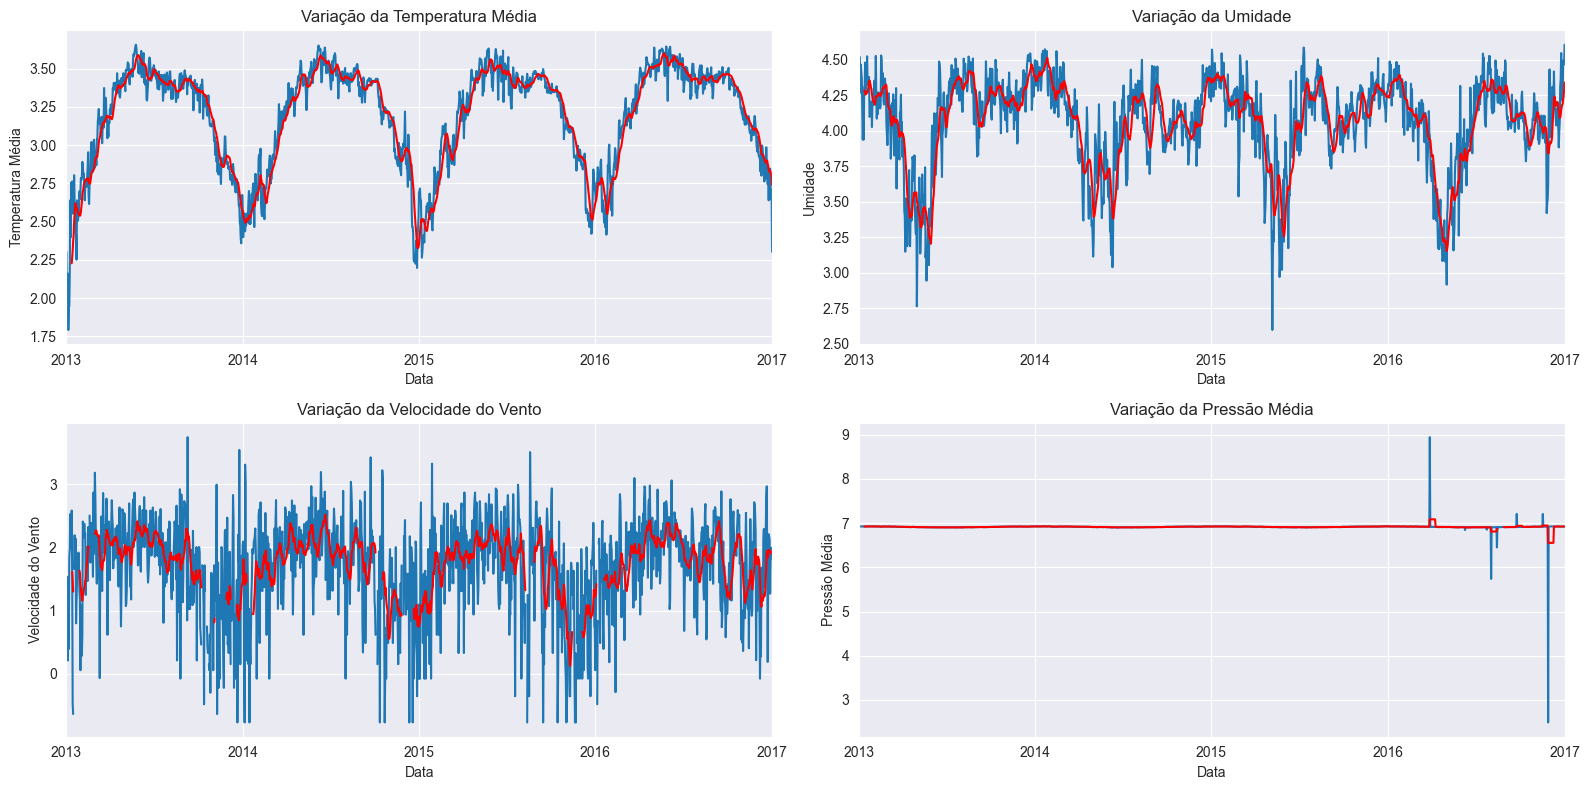

In [461]:
df_log = np.log(df_train)
ma_log = df_log.rolling(12).mean() #type: ignore
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
df_log.meantemp.plot(ax=ax[0][0], legend=False) #type: ignore
ma_log.meantemp.plot(ax=ax[0][0], legend=False, color='r')
ax[0][0].set_xlabel('Data')
ax[0][0].set_ylabel('Temperatura Média')
ax[0][0].set_title('Variação da Temperatura Média')
df_log.humidity.plot(ax=ax[0][1], legend=False) #type: ignore
ma_log.humidity.plot(ax=ax[0][1], legend=False, color='r')
ax[0][1].set_xlabel('Data')
ax[0][1].set_ylabel('Umidade')
ax[0][1].set_title('Variação da Umidade')
df_log.wind_speed.plot(ax=ax[1][0], legend=False) #type: ignore
ma_log.wind_speed.plot(ax=ax[1][0], legend=False, color='r')
ax[1][0].set_xlabel('Data')
ax[1][0].set_ylabel('Velocidade do Vento')
ax[1][0].set_title('Variação da Velocidade do Vento')
df_log.meanpressure.plot(ax=ax[1][1], legend=False) #type: ignore
ma_log.meanpressure.plot(ax=ax[1][1], legend=False, color='r')
ax[1][1].set_xlabel('Data')
ax[1][1].set_ylabel('Pressão Média')
ax[1][1].set_title('Variação da Pressão Média')
plt.tight_layout()
plt.show()

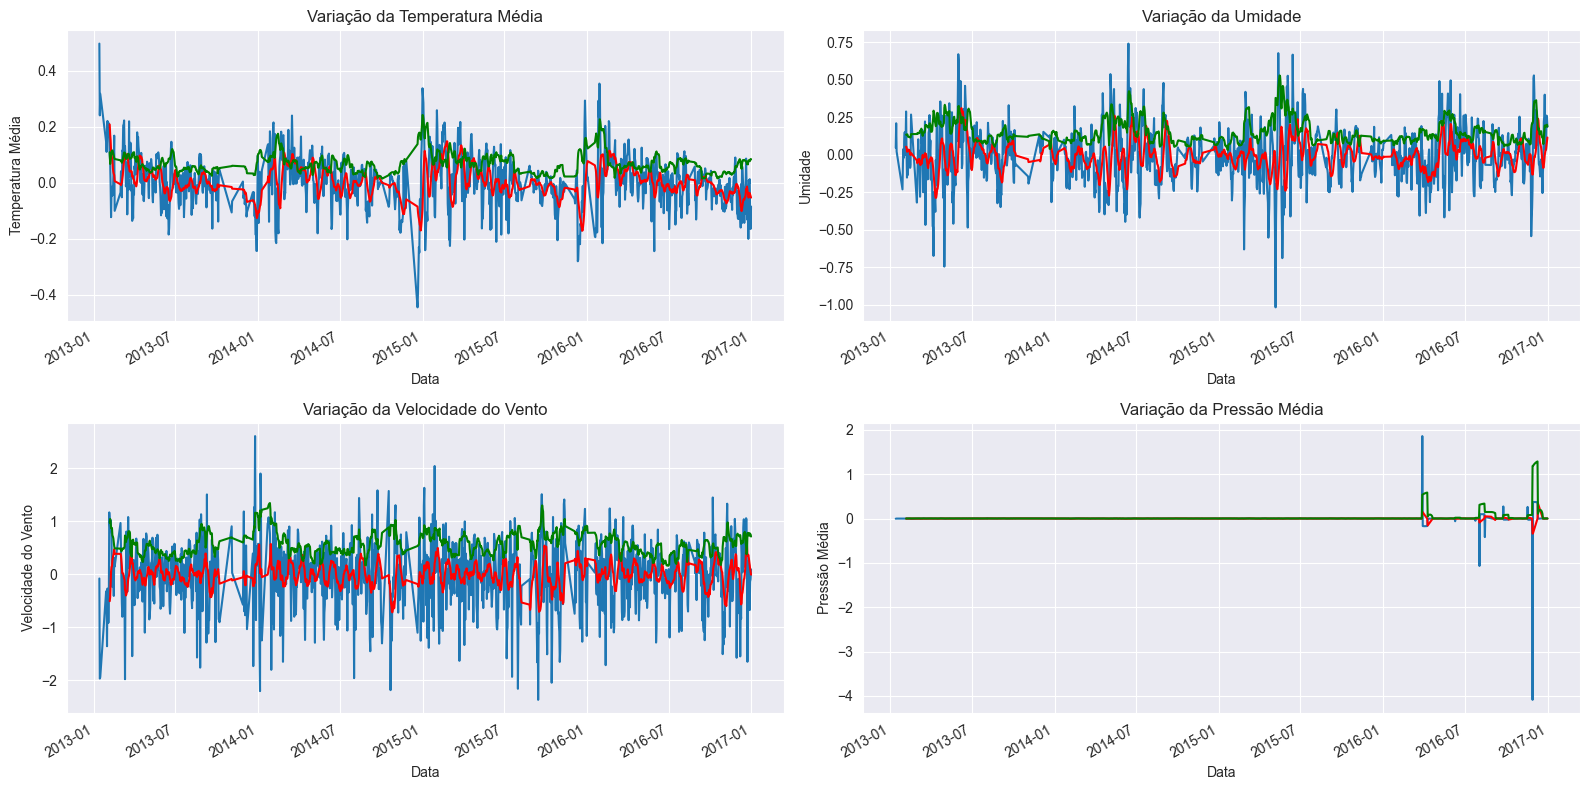

In [462]:
df_sm = (df_log - ma_log).dropna()
ma_sm = df_sm.rolling(12).mean()
std = df_sm.rolling(12).std()
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
df_sm.meantemp.plot(ax=ax[0][0], legend=False)
ma_sm.meantemp.plot(ax=ax[0][0], legend=False, color='r')
std.meantemp.plot(ax=ax[0][0], legend=False, color='g')
ax[0][0].set_xlabel('Data')
ax[0][0].set_ylabel('Temperatura Média')
ax[0][0].set_title('Variação da Temperatura Média')
df_sm.humidity.plot(ax=ax[0][1], legend=False)
ma_sm.humidity.plot(ax=ax[0][1], legend=False, color='r')
std.humidity.plot(ax=ax[0][1], legend=False, color='g')
ax[0][1].set_xlabel('Data')
ax[0][1].set_ylabel('Umidade')
ax[0][1].set_title('Variação da Umidade')
df_sm.wind_speed.plot(ax=ax[1][0], legend=False)
ma_sm.wind_speed.plot(ax=ax[1][0], legend=False, color='r')
std.wind_speed.plot(ax=ax[1][0], legend=False, color='g')
ax[1][0].set_xlabel('Data')
ax[1][0].set_ylabel('Velocidade do Vento')
ax[1][0].set_title('Variação da Velocidade do Vento')
df_sm.meanpressure.plot(ax=ax[1][1], legend=False)
ma_sm.meanpressure.plot(ax=ax[1][1], legend=False, color='r')
std.meanpressure.plot(ax=ax[1][1], legend=False, color='g')
ax[1][1].set_xlabel('Data')
ax[1][1].set_ylabel('Pressão Média')
ax[1][1].set_title('Variação da Pressão Média')
plt.tight_layout()
plt.show()

In [463]:
augmented_dickey_fuller(df_sm.meantemp.values)

Teste ADf
Teste estatistico: -6.6800134977823795
P-Value: 4.366225827851803e-09
Valores criticos:
	1%: -3.4356560275160835
	5%: -2.8638831211270817
	10%: -2.568017509711682


In [464]:
augmented_dickey_fuller(df_sm.humidity.values)

Teste ADf
Teste estatistico: -13.633937762964065
P-Value: 1.7024912661746997e-25
Valores criticos:
	1%: -3.435630320520318
	5%: -2.863871779019612
	10%: -2.56801146937726


In [465]:
augmented_dickey_fuller(df_sm.wind_speed.values)

Teste ADf
Teste estatistico: -12.343726489520217
P-Value: 6.037645231479147e-23
Valores criticos:
	1%: -3.4356646522289815
	5%: -2.863886926389418
	10%: -2.568019536239491


In [466]:
augmented_dickey_fuller(df_sm.meanpressure.values)

Teste ADf
Teste estatistico: -16.10174074944645
P-Value: 5.12287787950171e-29
Valores criticos:
	1%: -3.435638861796935
	5%: -2.863875547501718
	10%: -2.5680134763122906


- Derivadas de um número de polinômio de primeiro grau deixando mais estacionaria.

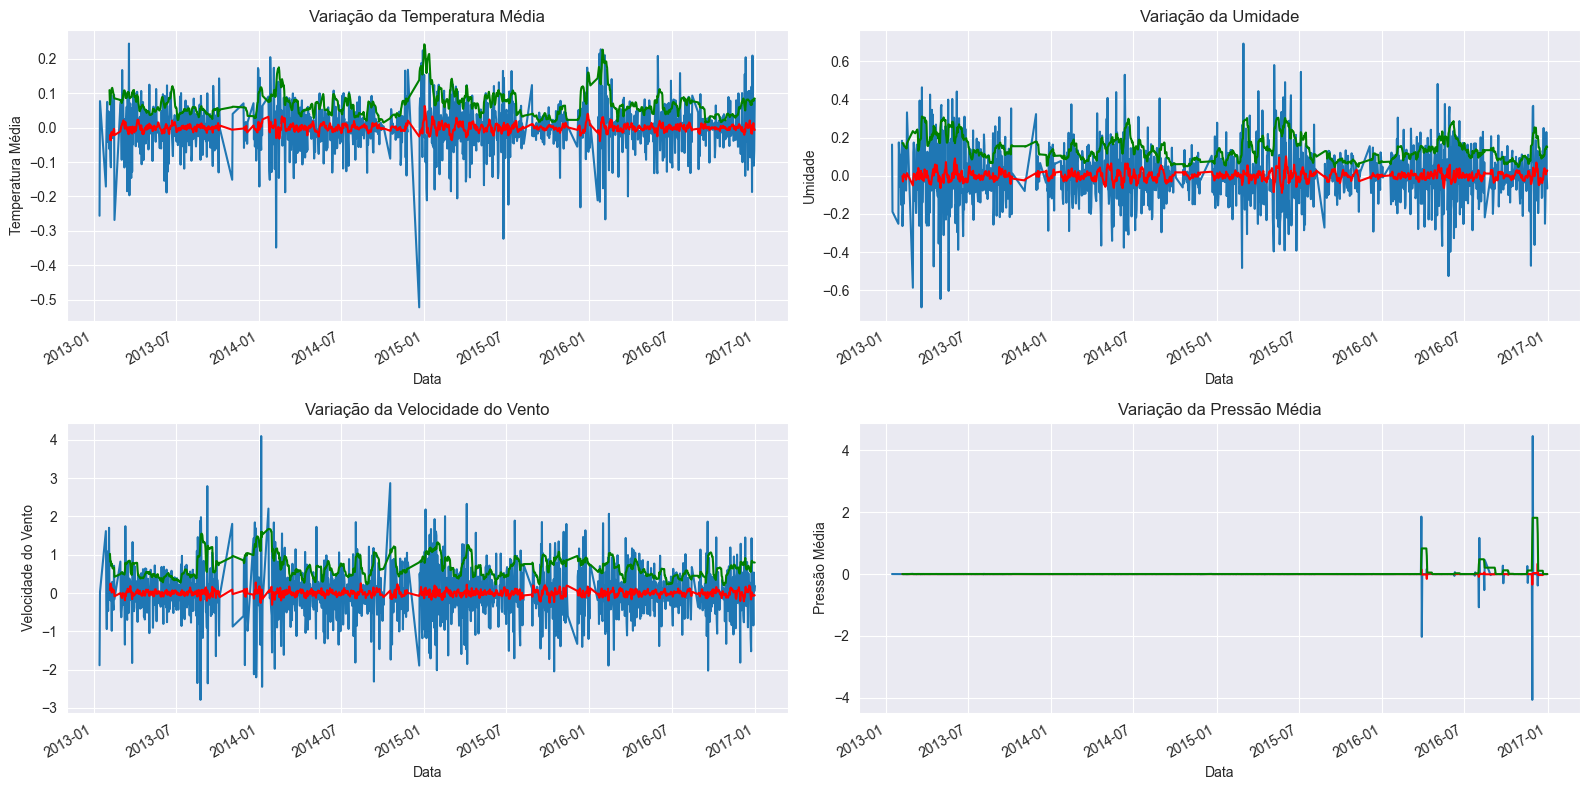

In [467]:
df_diff = df_sm.diff(1)# primeira derivara
ma_diff = df_diff.rolling(12).mean()# 12 meses
std_diff = df_diff.rolling(12).std()# 12 meses
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
df_diff.meantemp.plot(ax=ax[0][0], legend=False)
ma_diff.meantemp.plot(ax=ax[0][0], legend=False, color='r')
std.meantemp.plot(ax=ax[0][0], legend=False, color='g')
ax[0][0].set_xlabel('Data')
ax[0][0].set_ylabel('Temperatura Média')
ax[0][0].set_title('Variação da Temperatura Média')
df_diff.humidity.plot(ax=ax[0][1], legend=False)
ma_diff.humidity.plot(ax=ax[0][1], legend=False, color='r')
std_diff.humidity.plot(ax=ax[0][1], legend=False, color='g')
ax[0][1].set_xlabel('Data')
ax[0][1].set_ylabel('Umidade')
ax[0][1].set_title('Variação da Umidade')
df_diff.wind_speed.plot(ax=ax[1][0], legend=False)
ma_diff.wind_speed.plot(ax=ax[1][0], legend=False, color='r')
std_diff.wind_speed.plot(ax=ax[1][0], legend=False, color='g')
ax[1][0].set_xlabel('Data')
ax[1][0].set_ylabel('Velocidade do Vento')
ax[1][0].set_title('Variação da Velocidade do Vento')
df_diff.meanpressure.plot(ax=ax[1][1], legend=False)
ma_diff.meanpressure.plot(ax=ax[1][1], legend=False, color='r')
std_diff.meanpressure.plot(ax=ax[1][1], legend=False, color='g')
ax[1][1].set_xlabel('Data')
ax[1][1].set_ylabel('Pressão Média')
ax[1][1].set_title('Variação da Pressão Média')
plt.tight_layout()
plt.show()

In [468]:
augmented_dickey_fuller(df_diff.meantemp.dropna().values)

Teste ADf
Teste estatistico: -12.350340960203464
P-Value: 5.844727736839578e-23
Valores criticos:
	1%: -3.4356950607889254
	5%: -2.863900342696613
	10%: -2.568026681232353


In [469]:
augmented_dickey_fuller(df_diff.humidity.dropna().values)

Teste ADf
Teste estatistico: -12.9419177957572
P-Value: 3.520049025797706e-24
Valores criticos:
	1%: -3.4356950607889254
	5%: -2.863900342696613
	10%: -2.568026681232353


In [470]:
augmented_dickey_fuller(df_diff.wind_speed.dropna().values)

Teste ADf
Teste estatistico: -14.81021102674028
P-Value: 2.035853960458818e-27
Valores criticos:
	1%: -3.435699433298302
	5%: -2.863902271843875
	10%: -2.5680277086214076


In [471]:
augmented_dickey_fuller(df_diff.meanpressure.dropna().values)

Teste ADf
Teste estatistico: -14.182832190335679
P-Value: 1.9153228226878285e-26
Valores criticos:
	1%: -3.435699433298302
	5%: -2.863902271843875
	10%: -2.5680277086214076


p-value negativo e teste estatístico menor que os valores criticos: meantemp é estacionaria

- Aplicar a transformada de Fourier para teste

#### ARIMA
- AR: Autorregressivo
-  I: Integrado
-  MA: Moving Average-Media Móvel

> A(x, y, z) - ACF, PACF
> ACF autocorrelação em uma variável, período correlacionado com outro, correlação direta e indireta
> PACF autocorrelação parcial, correlação direta
---
- 5% ACF
- 1.96/sqrt(N-d) -> N número de pontos do dataframe e d é o número de vezes qeu nos diferenciamos o dataframe

In [472]:
lag_acf_meantemp = acf(df_diff.meantemp.dropna(), nlags=30)
lag_acf_humidity = acf(df_diff.humidity.dropna(), nlags=30)
lag_acf_wind_speed = acf(df_diff.wind_speed.dropna(), nlags=30)
lag_acf_meanpressure = acf(df_diff.meanpressure.dropna(), nlags=30)

lag_pacf_meantemp = pacf(df_diff.meantemp.dropna(), nlags=30)
lag_pacf_humidity = pacf(df_diff.humidity.dropna(), nlags=30)
lag_pacf_wind_speed = pacf(df_diff.wind_speed.dropna(), nlags=30)
lag_pacf_meanpressure = pacf(df_diff.meanpressure.dropna(), nlags=30)

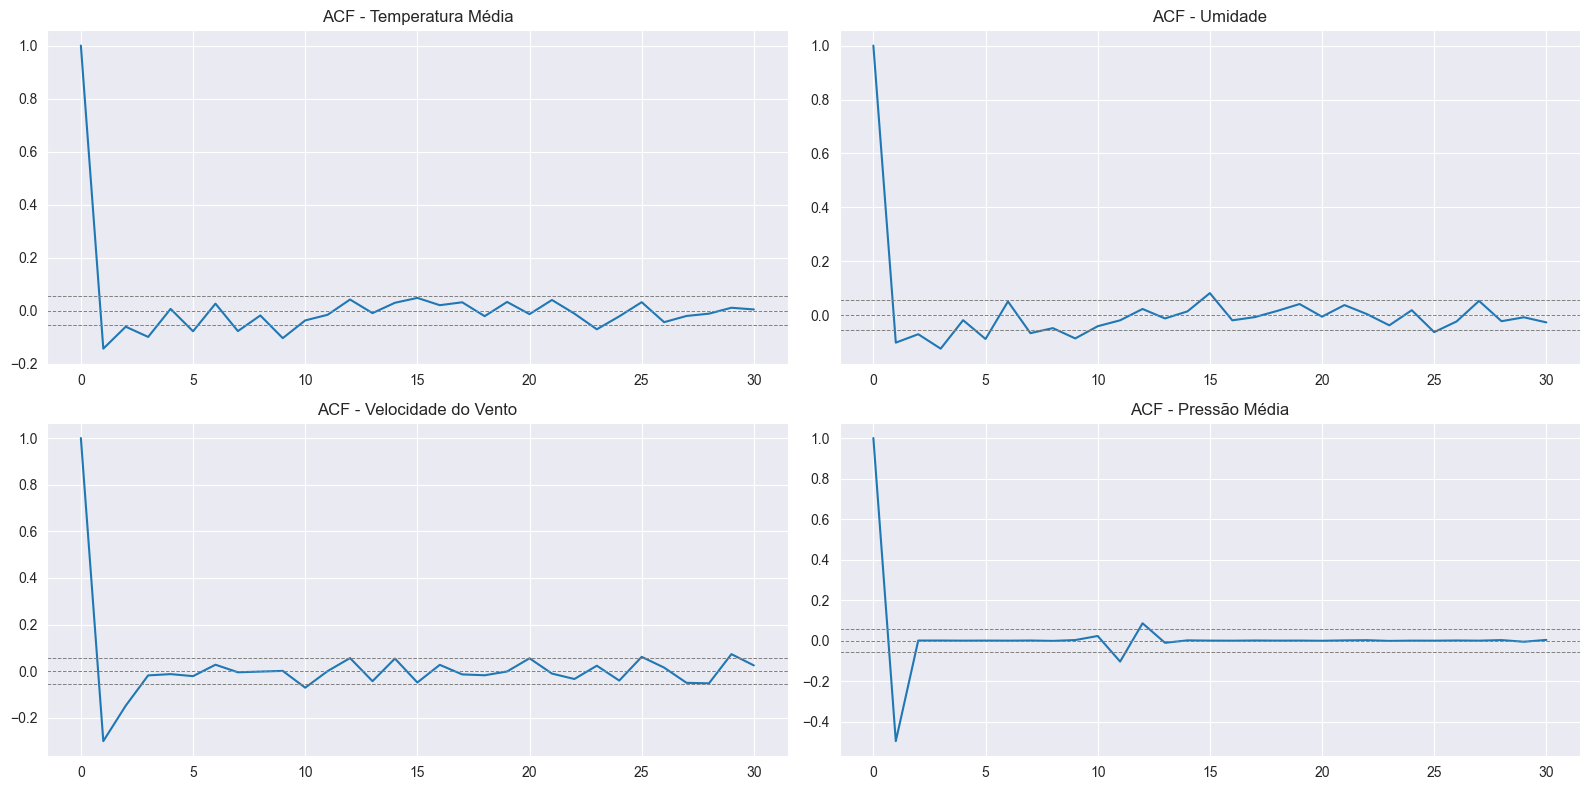

In [473]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax[0][0].plot(lag_acf_meantemp)
ax[0][0].axhline(y=-1.96/(np.sqrt((len(df_diff.meantemp) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][0].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[0][0].axhline(y=1.96/(np.sqrt((len(df_diff.meantemp) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][0].set_title('ACF - Temperatura Média')
ax[0][1].plot(lag_acf_humidity)
ax[0][1].axhline(y=-1.96/(np.sqrt((len(df_diff.humidity) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][1].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[0][1].axhline(y=1.96/(np.sqrt((len(df_diff.humidity) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][1].set_title('ACF - Umidade')
ax[1][0].plot(lag_acf_wind_speed)
ax[1][0].axhline(y=-1.96/(np.sqrt((len(df_diff.wind_speed) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][0].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[1][0].axhline(y=1.96/(np.sqrt((len(df_diff.wind_speed) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][0].set_title('ACF - Velocidade do Vento')
ax[1][1].plot(lag_acf_meanpressure)
ax[1][1].axhline(y=-1.96/(np.sqrt((len(df_diff.meanpressure) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][1].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[1][1].axhline(y=1.96/(np.sqrt((len(df_diff.meanpressure) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][1].set_title('ACF - Pressão Média')
plt.tight_layout()
plt.show()

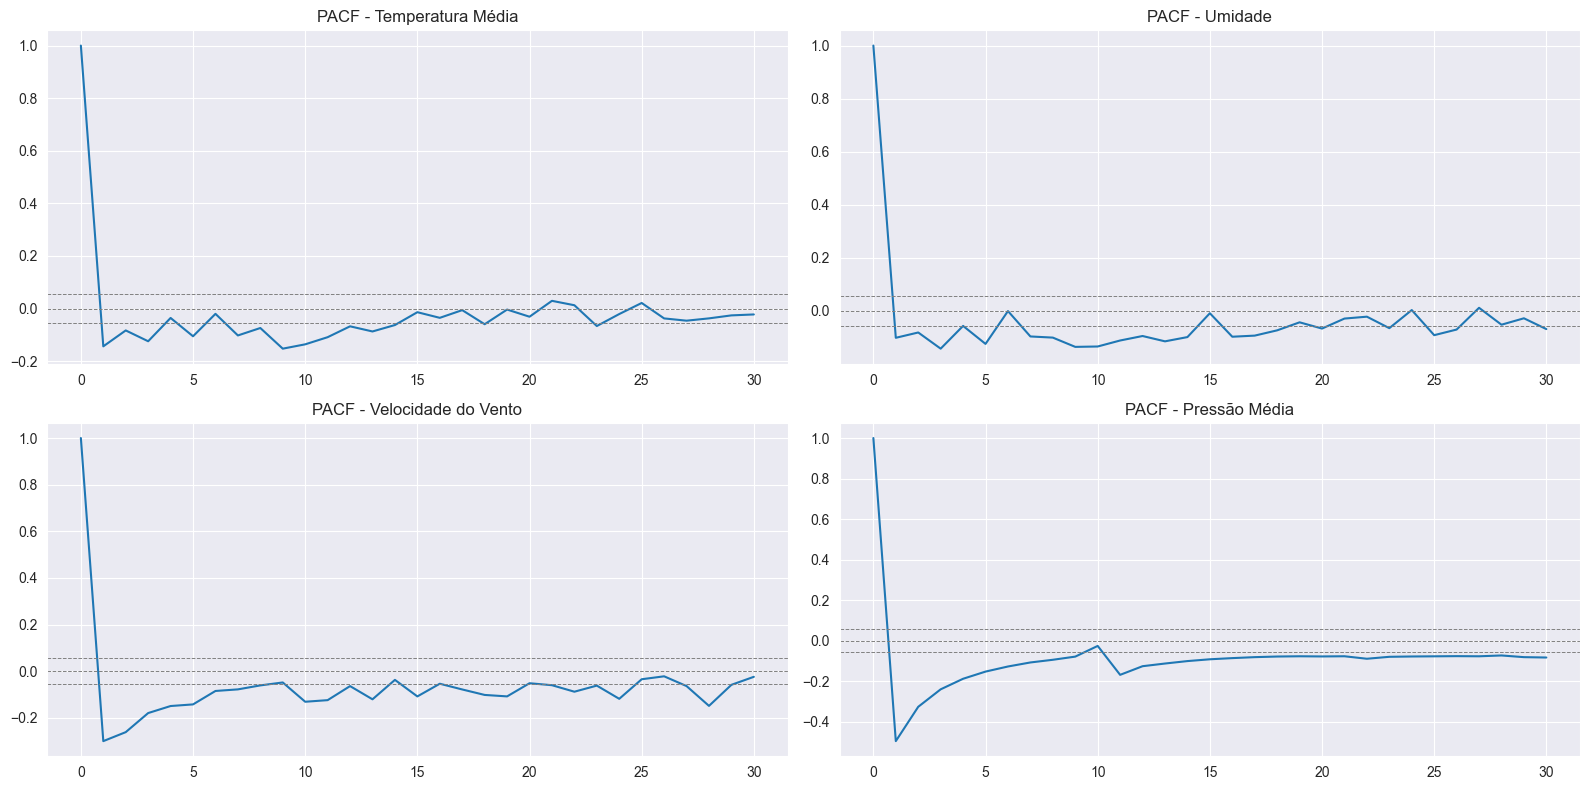

In [474]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
ax[0][0].plot(lag_pacf_meantemp)
ax[0][0].axhline(y=-1.96/(np.sqrt((len(df_diff.meantemp) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][0].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[0][0].axhline(y=1.96/(np.sqrt((len(df_diff.meantemp) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][0].set_title('PACF - Temperatura Média')
ax[0][1].plot(lag_pacf_humidity)
ax[0][1].axhline(y=-1.96/(np.sqrt((len(df_diff.humidity) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][1].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[0][1].axhline(y=1.96/(np.sqrt((len(df_diff.humidity) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[0][1].set_title('PACF - Umidade')
ax[1][0].plot(lag_pacf_wind_speed)
ax[1][0].axhline(y=-1.96/(np.sqrt((len(df_diff.wind_speed) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][0].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[1][0].axhline(y=1.96/(np.sqrt((len(df_diff.wind_speed) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][0].set_title('PACF - Velocidade do Vento')
ax[1][1].plot(lag_pacf_meanpressure)
ax[1][1].axhline(y=-1.96/(np.sqrt((len(df_diff.meanpressure) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][1].axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
ax[1][1].axhline(y=1.96/(np.sqrt((len(df_diff.meanpressure) -1))), linestyle='--', color='gray', linewidth=0.7)
ax[1][1].set_title('PACF - Pressão Média')
plt.tight_layout()
plt.show()

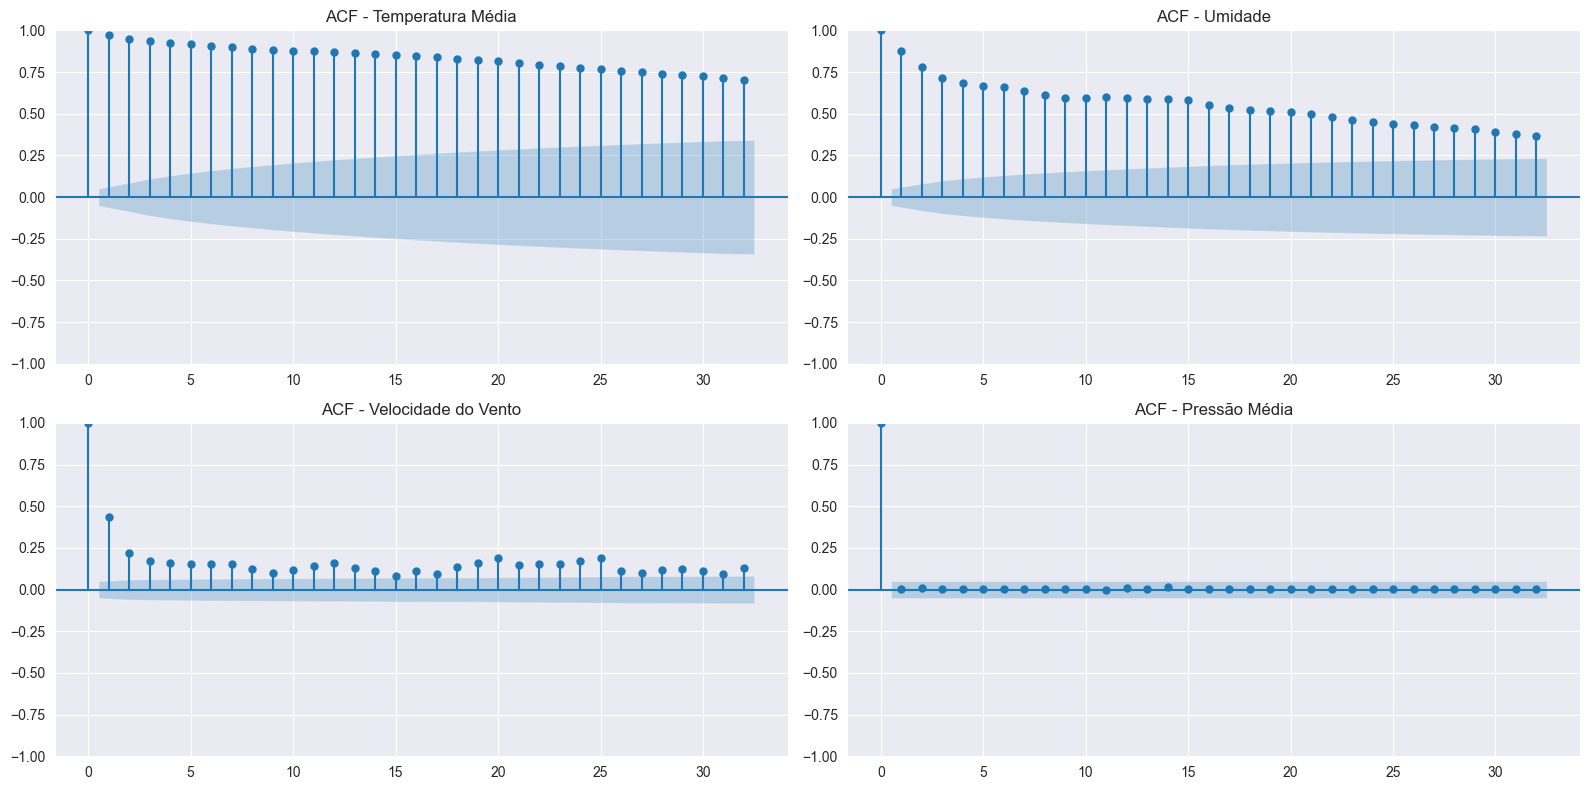

In [475]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plot_acf(df_train.meantemp, ax=ax[0][0])
ax[0][0].set_title('ACF - Temperatura Média')
plot_acf(df_train.humidity, ax=ax[0][1])
ax[0][1].set_title('ACF - Umidade')
plot_acf(df_train.wind_speed, ax=ax[1][0])
ax[1][0].set_title('ACF - Velocidade do Vento')
plot_acf(df_train.meanpressure, ax=ax[1][1])
ax[1][1].set_title('ACF - Pressão Média')
plt.tight_layout()
plt.show()

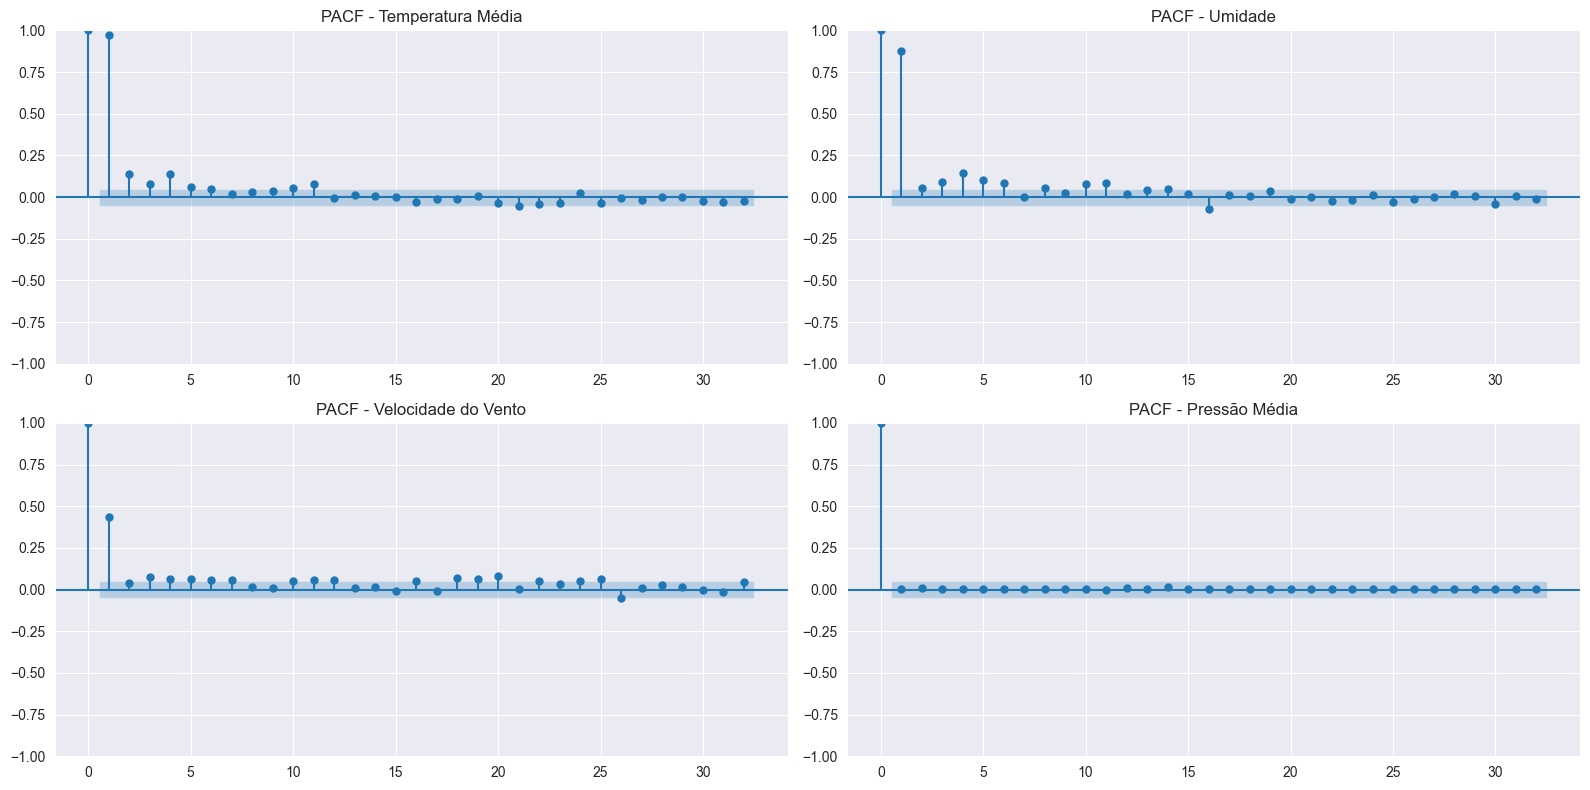

In [476]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plot_pacf(df_train.meantemp, ax=ax[0][0])
ax[0][0].set_title('PACF - Temperatura Média')
plot_pacf(df_train.humidity, ax=ax[0][1])
ax[0][1].set_title('PACF - Umidade')
plot_pacf(df_train.wind_speed, ax=ax[1][0])
ax[1][0].set_title('PACF - Velocidade do Vento')
plot_pacf(df_train.meanpressure, ax=ax[1][1])
ax[1][1].set_title('PACF - Pressão Média')
plt.tight_layout()
plt.show()

## Construção do modelo

In [477]:
train = pd.read_csv('Data/DailyDelhiClimateTrain.csv', parse_dates=[0])
train = pd.melt(train, id_vars=['date'], var_name='unique_id', value_name='y')
train.rename(columns={'date': 'ds'}, inplace=True)
train.head()

ds unique_id          y
0 2013-01-01  meantemp  10.000000
1 2013-01-02  meantemp   7.400000
2 2013-01-03  meantemp   7.166667
3 2013-01-04  meantemp   8.666667
4 2013-01-05  meantemp   6.000000

In [478]:
test = pd.read_csv('Data/DailyDelhiClimateTest.csv', parse_dates=[0])
test = pd.melt(test, id_vars=['date'], var_name='unique_id', value_name='y')
test.rename(columns={'date': 'ds'}, inplace=True)
test.head()

ds unique_id          y
0 2017-01-01  meantemp  15.913043
1 2017-01-02  meantemp  18.500000
2 2017-01-03  meantemp  17.111111
3 2017-01-04  meantemp  18.700000
4 2017-01-05  meantemp  18.388889

In [479]:
h = test['ds'].nunique()
h

114

#### erro percentual absoluto através de pesos

In [480]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

##### baseline
- Prever o valor do ultimo período conhecido(ultimo dia)

In [481]:
bl_model = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
bl_model.fit(train)
forecast_df = bl_model.predict(h=h, level=[95])
forecast_df = forecast_df.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_df.dropna(inplace=True)
forecast_df.head()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds  Naive  Naive-lo-95  Naive-hi-95          y
0  humidity 2017-01-02  100.0    83.825653   116.174347  77.222222
1  humidity 2017-01-03  100.0    77.126022   122.873978  81.888889
2  humidity 2017-01-04  100.0    71.985214   128.014786  70.050000
3  humidity 2017-01-05  100.0    67.651306   132.348694  74.944444
4  humidity 2017-01-06  100.0    63.833065   136.166931  79.318182

WMAPE: 6.30%


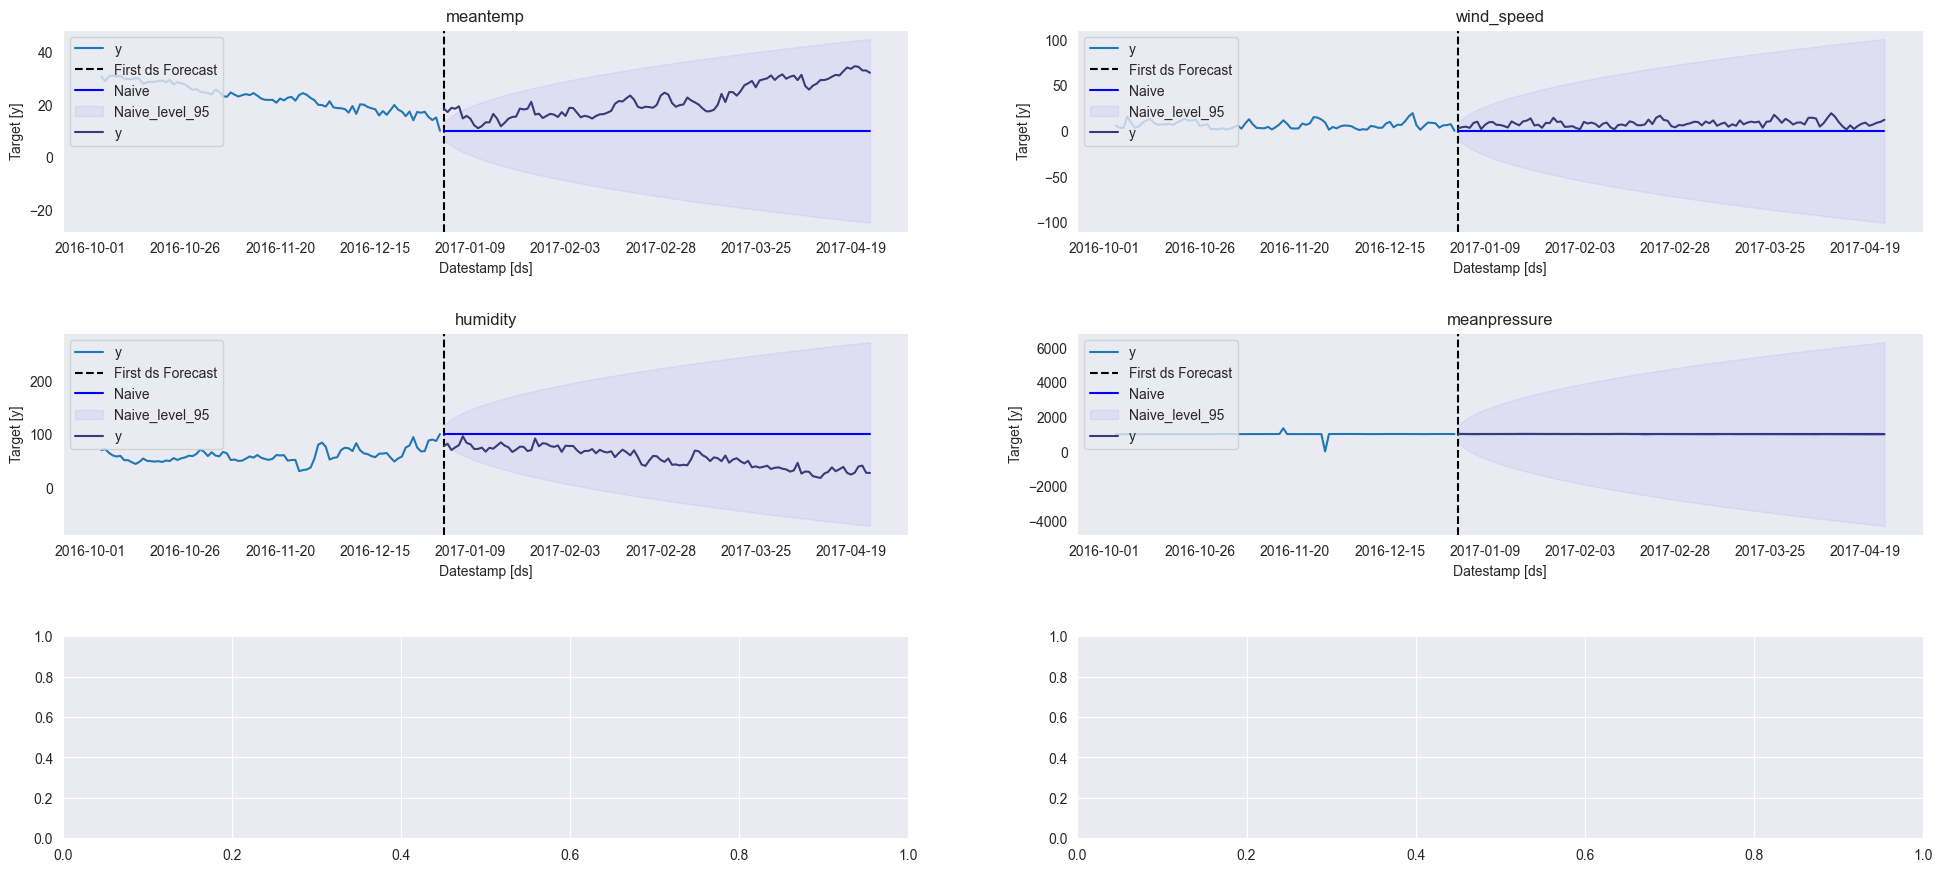

In [482]:
wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")
bl_model.plot(train, forecast_df, level=[95], unique_ids=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], engine='matplotlib', max_insample_length=90)

##### baseline com sazonalidade
- 7 dias

In [486]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(train)
forecast_dfs = model_s.predict(h=h, level=[95])
forecast_dfs = forecast_dfs.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_dfs.dropna(inplace=True)
forecast_dfs.head()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds  SeasonalNaive  SeasonalNaive-lo-95  \
0  humidity 2017-01-02      74.857140           -39.200592   
1  humidity 2017-01-03      67.550003           -46.507729   
2  humidity 2017-01-04      68.043480           -46.014252   
3  humidity 2017-01-05      87.857140           -26.200594   
4  humidity 2017-01-06      89.666664           -24.391069   

   SeasonalNaive-hi-95          y  
0           188.914871  77.222222  
1           181.607742  81.888889  
2           182.101212  70.050000  
3           201.914871  74.944444  
4           203.724396  79.318182

WMAPE: 4.07%


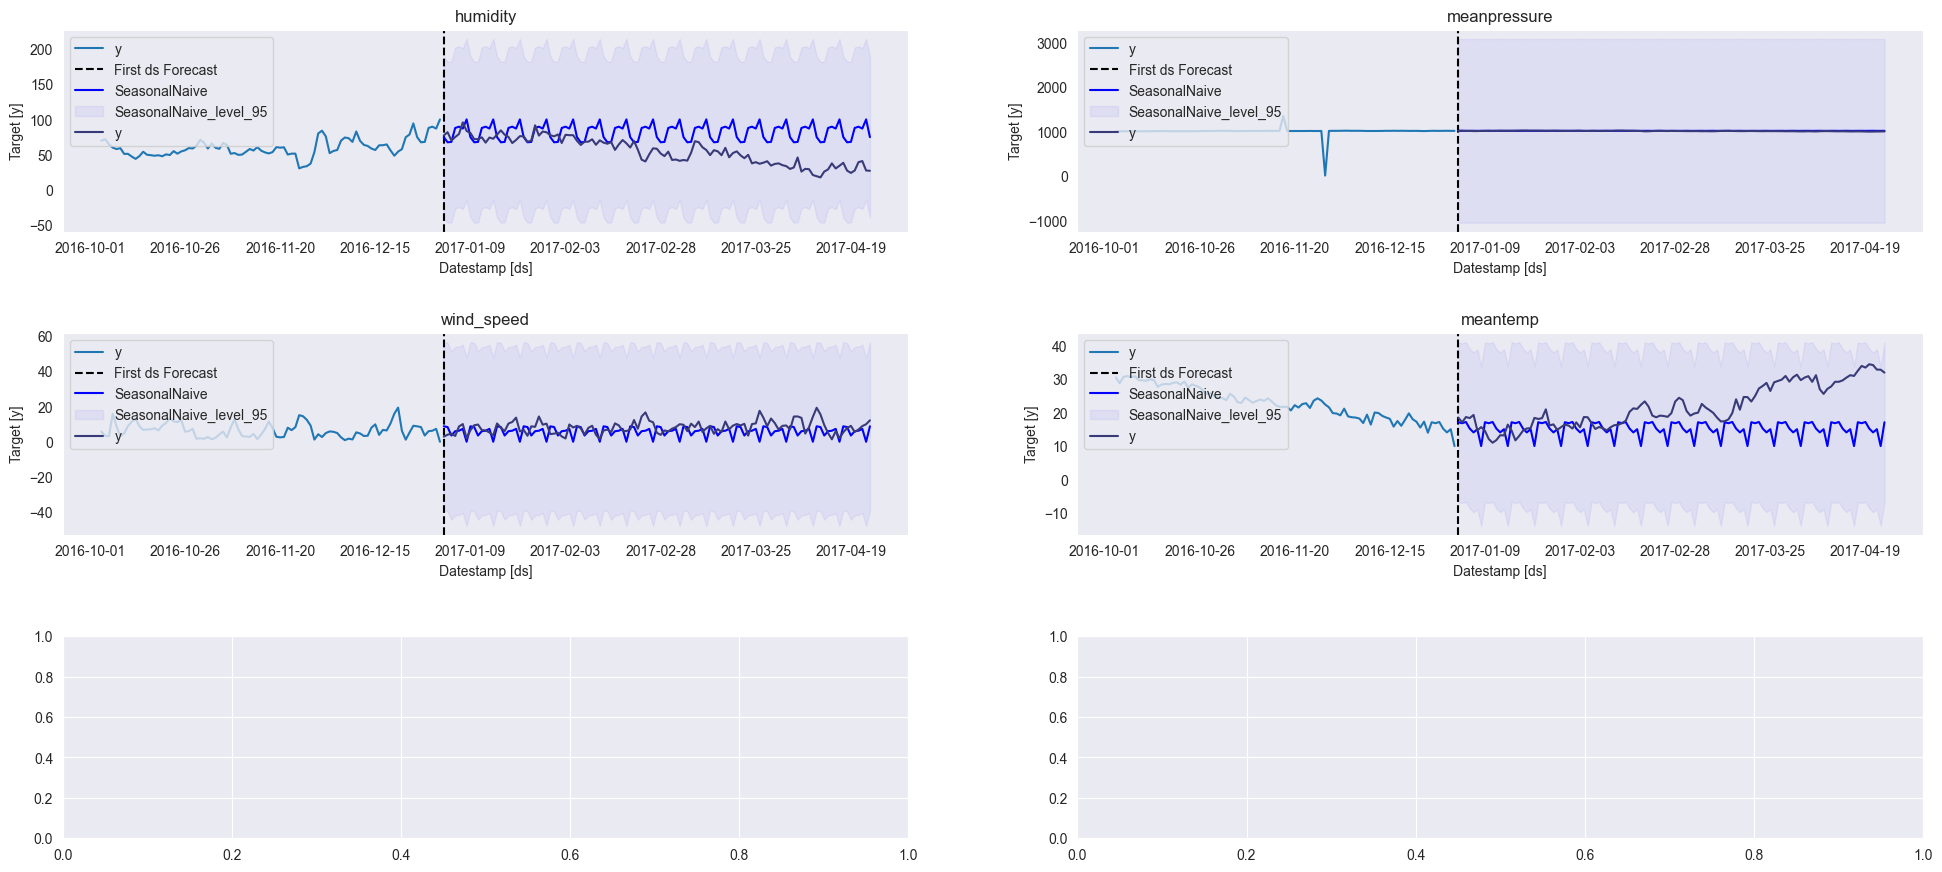

In [488]:
wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")
model_s.plot(train, forecast_dfs, level=[95], unique_ids=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], engine='matplotlib', max_insample_length=90)

#### baseline com janela de sazonalidade

In [524]:
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=4)], freq='D', n_jobs=-1)# 4 WMAPE: 3.12%
model_sm.fit(train)
forecast_dfsm = model_sm.predict(h=h, level=[95])
forecast_dfsm = forecast_dfsm.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_dfsm.dropna(inplace=True)
forecast_dfsm.head()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds     SeasWA          y
0  humidity 2017-01-02  62.851730  77.222222
1  humidity 2017-01-03  62.089100  81.888889
2  humidity 2017-01-04  63.826149  70.050000
3  humidity 2017-01-05  68.909821  74.944444
4  humidity 2017-01-06  73.942360  79.318182

WMAPE: 3.12%


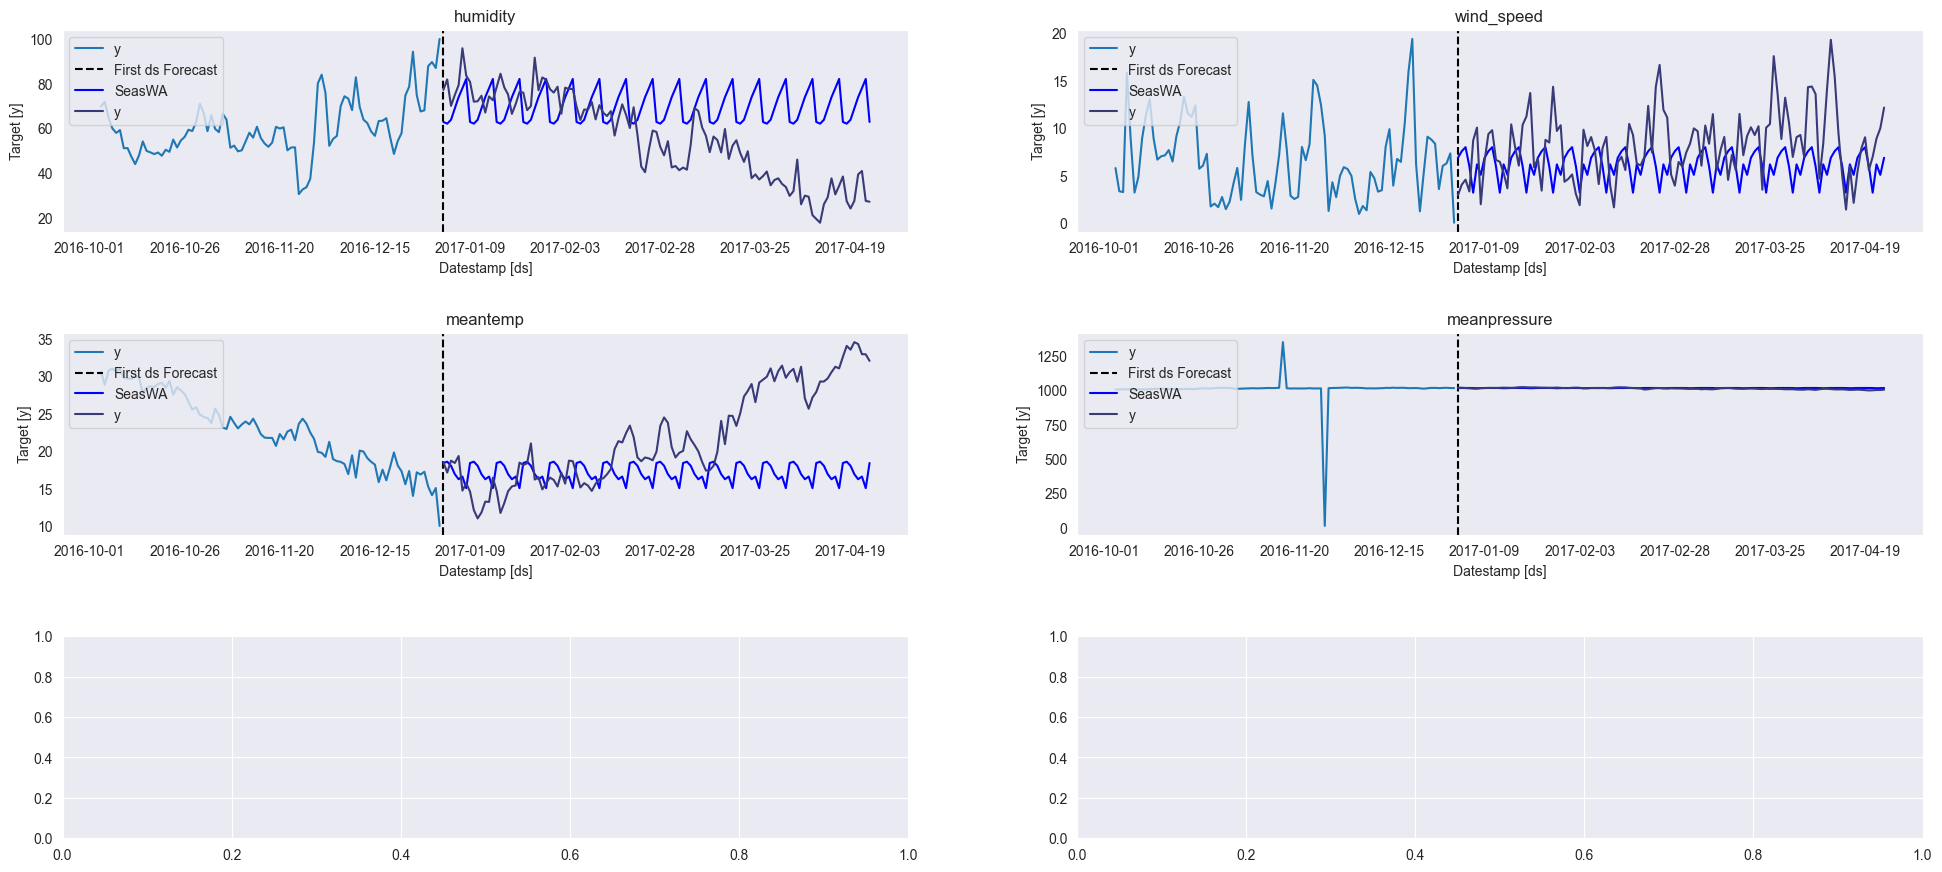

In [525]:
wmape3 = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f"WMAPE: {wmape3:.2%}")
model_sm.plot(train, forecast_dfsm, level=[95], unique_ids=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], engine='matplotlib', max_insample_length=90)

#### ARIMA
---
- AR: Alha para as vendas do passado e tenta achar uma correlação futura
- I: Quantidade que a série foi diferenciada
- MA: Média model

In [528]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(train)
forecast_dfa = model_a.predict(h=h, level=[95])
forecast_dfa = forecast_dfa.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_dfa.dropna(inplace=True)
forecast_dfa.head()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds  AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95          y
0  humidity 2017-01-02  93.170387        77.833000       108.507774  77.222222
1  humidity 2017-01-03  88.746086        69.244316       108.247849  81.888889
2  humidity 2017-01-04  85.205116        63.705463       106.704773  70.050000
3  humidity 2017-01-05  83.745384        61.351620       106.139153  74.944444
4  humidity 2017-01-06  83.692596        60.730618       106.654572  79.318182

WMAPE: 70.97%


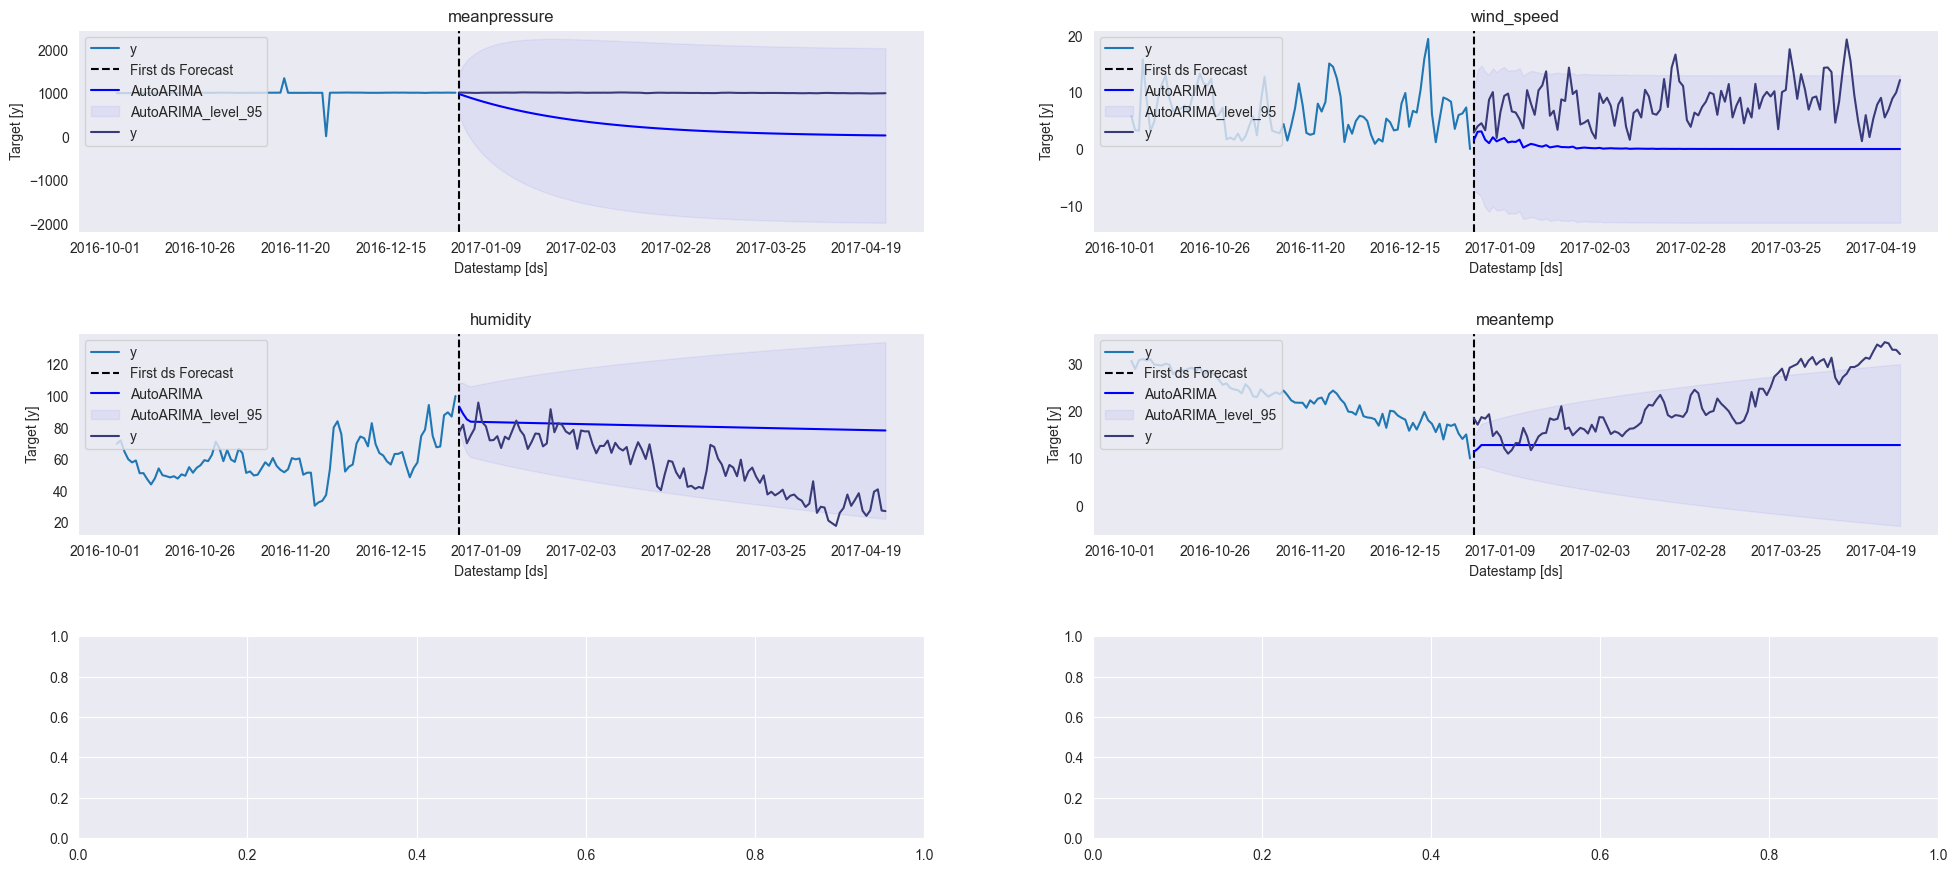

In [529]:
wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")
model_a.plot(train, forecast_dfa, level=[95], unique_ids=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], engine='matplotlib', max_insample_length=90)

In [532]:
model_u = StatsForecast(
    models=[
        Naive(),
        SeasonalNaive(season_length=7),
        AutoARIMA(season_length=7),
        SeasonalWindowAverage(season_length=7, window_size=4)
    ],
    freq='D',
    n_jobs=-1
)
model_u.fit(train)
forecast_dfu = model_u.predict(h=h, level=[95])
forecast_dfu = forecast_dfu.reset_index().merge(test, on=['ds', 'unique_id'], how='left')
forecast_dfu.dropna(inplace=True)
forecast_dfu.head()

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


unique_id         ds  Naive  Naive-lo-95  Naive-hi-95  SeasonalNaive  \
0  humidity 2017-01-02  100.0    83.825653   116.174347      74.857140   
1  humidity 2017-01-03  100.0    77.126022   122.873978      67.550003   
2  humidity 2017-01-04  100.0    71.985214   128.014786      68.043480   
3  humidity 2017-01-05  100.0    67.651306   132.348694      87.857140   
4  humidity 2017-01-06  100.0    63.833065   136.166931      89.666664   

   SeasonalNaive-lo-95  SeasonalNaive-hi-95  AutoARIMA  AutoARIMA-lo-95  \
0           -39.200592           188.914871  93.170387        77.833000   
1           -46.507729           181.607742  88.746086        69.244316   
2           -46.014252           182.101212  85.205116        63.705463   
3           -26.200594           201.914871  83.745384        61.351620   
4           -24.391069           203.724396  83.692596        60.730618   

   AutoARIMA-hi-95     SeasWA          y  
0       108.507774  62.851730  77.222222  
1       108.247849  62.089100  81.888889  
2       106.704773  63.826149  70.050000  
3       106.139153  68.909821  74.944444  
4       106.654572  73.942360  79.318182

WMAPE: 6.30%
WMAPE: 4.07%
WMAPE: 70.97%
WMAPE: 3.12%


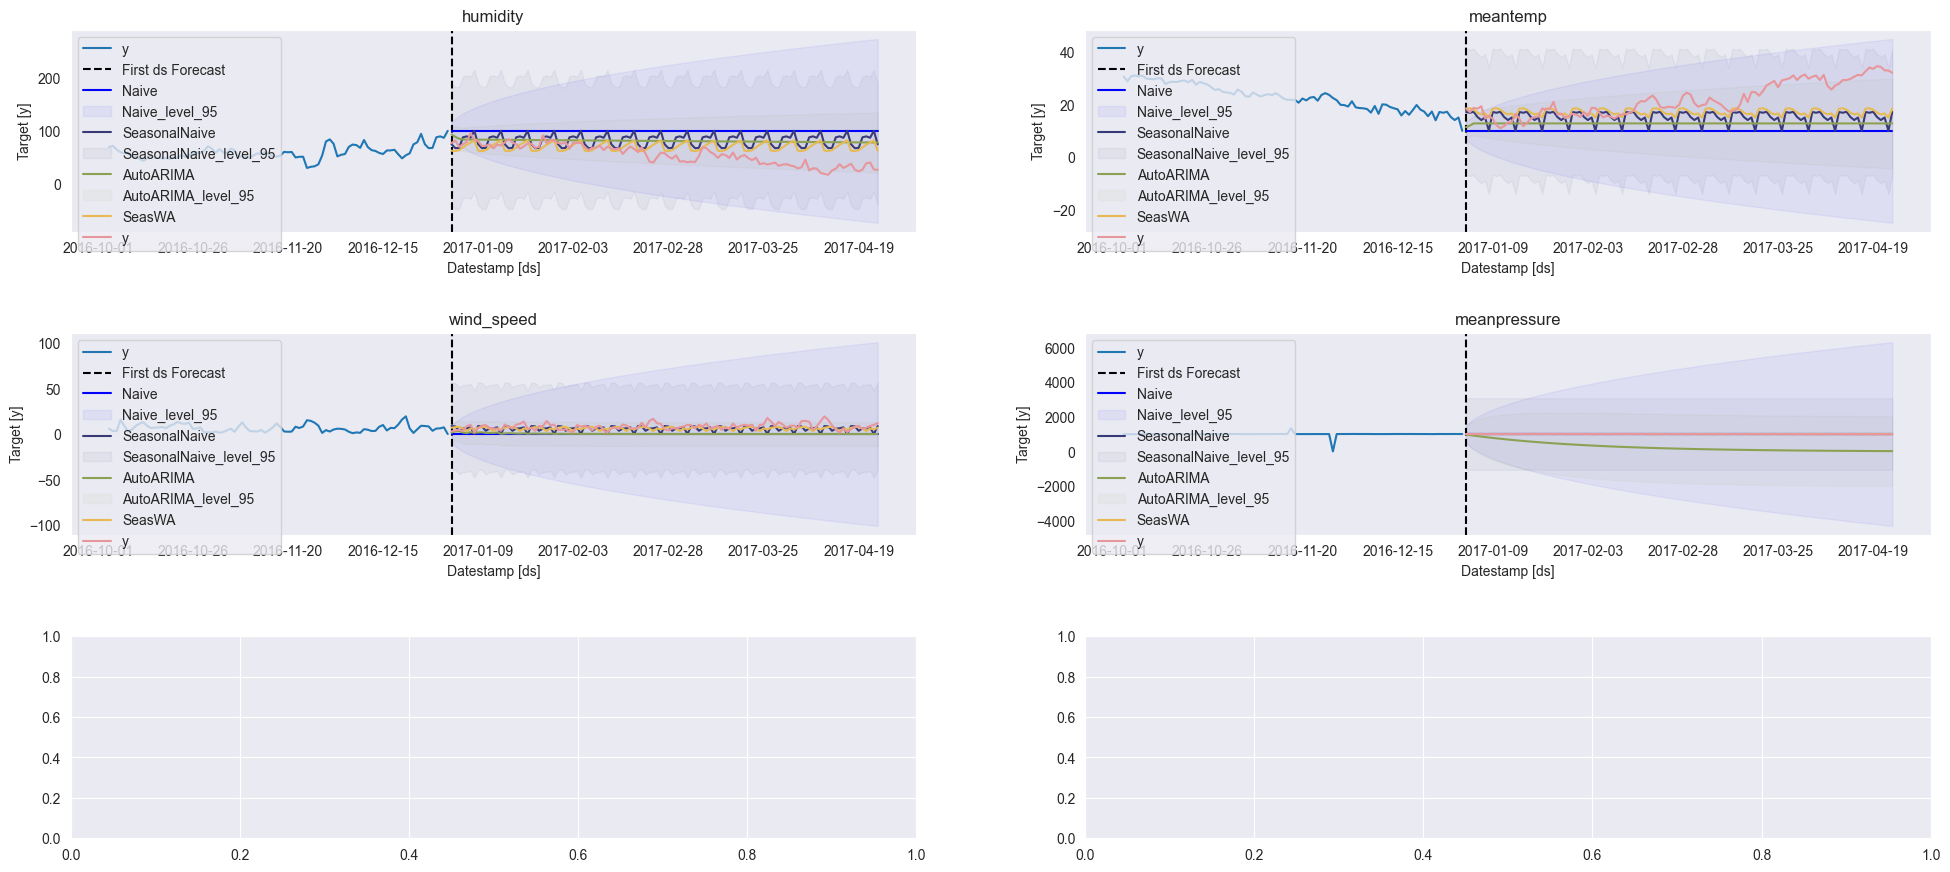

In [537]:
wmape5 = wmape(forecast_dfu['y'].values, forecast_dfu['Naive'].values)
print(f"WMAPE: {wmape5:.2%}")
wmape6 = wmape(forecast_dfu['y'].values, forecast_dfu['SeasonalNaive'].values)
print(f"WMAPE: {wmape6:.2%}")
wmape7 = wmape(forecast_dfu['y'].values, forecast_dfu['AutoARIMA'].values)
print(f"WMAPE: {wmape7:.2%}")
wmape8 = wmape(forecast_dfu['y'].values, forecast_dfu['SeasWA'].values)
print(f"WMAPE: {wmape8:.2%}")
model_u.plot(train, forecast_dfu, level=[95], unique_ids=['meantemp', 'humidity', 'wind_speed', 'meanpressure'], engine='matplotlib', max_insample_length=90)